In [1]:
import polaris as po
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
# from stepmix.stepmix import StepMix
import datamol as dm
import numpy as np

from molfeat.calc import RDKitDescriptors2D
from molfeat.trans import MoleculeTransformer

import pymc as pm
import pytensor.tensor as pt

/Users/robertarbon/mamba/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
import arviz as az
from scipy.stats import mode

In [2]:
all_train = pd.read_csv('data/train_inc_censored.csv')
train_ix = np.load('data/simpd_splits/train_inc_censored_idx.npy')
val_ix = np.load('data/simpd_splits/test_inc_censored_idx.npy')
train = all_train.iloc[train_ix, :]
val = all_train.iloc[val_ix, :]

## Step 0: Transform inputs and outputs

In [165]:
calc = RDKitDescriptors2D(replace_nan=True)
featurizer = MoleculeTransformer(calc, dtype=np.float64)
with dm.without_rdkit_log():
    feats = featurizer(X)

feats = pd.DataFrame(feats, columns=featurizer.columns)

/Users/robertarbon/mamba/envs/pymc_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [198]:
target = 'KSOL'
delta = 0.01
clip = (2, 400) # values <= or >= are grouped as one. 

missing_ix = np.isnan(train[target])
y = train.loc[~missing_ix, target].values
X = train.loc[~missing_ix, 'CXSMILES'].values


# n_unique_obs = np.unique(y).shape[0] - np.isnan(y).sum()
# y_ord, bins = pd.qcut(y, q=np.linspace(0, 1, int(100)), retbins=True, labels=False, duplicates='drop')
# # n_levels = int(n_unique_obs)



## Step 1: Simple Ordinal model

Just to get things working, we'll use the KSOL target with rdkit molecular features. I'm following https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html

In [145]:
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2))) * (max - min)
                + min,
            ]
        ),
    )

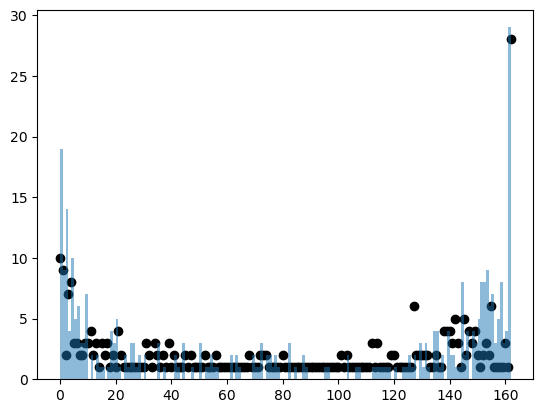

In [ ]:
# bins = np.concatenate([np.unique(np.sort(y))[::2], [400]])
bins =np.unique(np.sort(y))

y_ord, bins = pd.cut(y,bins=bins, include_lowest=True, labels=False, retbins=True, ordered=True, )
v, c = np.unique(y_ord, return_counts=True)

scale = sk.preprocessing.MinMaxScaler((np.min(v), np.max(v)))
y_scale = scale.fit_transform(y.reshape(-1, 1))

plt.scatter( v, c, color='black')
_= plt.hist(y_scale, bins=v, alpha=0.5)

In [217]:
v

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])

In [204]:
# bins = np.concatenate([np.unique(np.sort(y))[::2], [400]])
bins =np.unique(np.sort(y))

y_ord, bins = pd.cut(y,bins=bins, include_lowest=True, labels=False, retbins=True, ordered=True, )
print(np.unique(y_ord).max(), np.unique(y_ord).min(), np.unique(y_ord).shape[0])

X = np.clip([np.random.normal(loc=i, scale=20) for i in y], 2, 400)


n_levels = np.unique(y_ord).shape[0] 

priors = {"sigma": 10, "beta": [0, 1], "mu": np.linspace(0, n_levels, n_levels - 1)}

with pm.Model() as model:
    cutpoints = constrainedUniform(N=n_levels, min=0, max=n_levels)

    beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=1)

    
    mu = pm.Deterministic("mu", beta[0] * X)

    y_ = pm.OrderedProbit("y", cutpoints=cutpoints, eta=mu, observed=y_ord)
    idata = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, jitter_max_retries=1000)
    idata.extend(pm.sample_posterior_predictive(idata))

162 0 163


NotImplementedError: No JAX implementation for Op erfcx. Implementation is available if TensorFlow Probability is installed

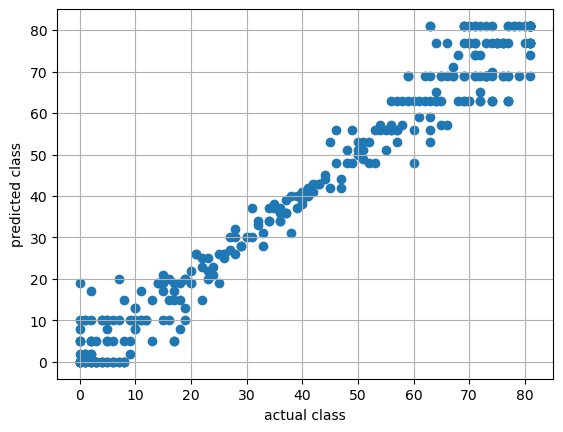

In [200]:
implied_class = az.extract(idata, var_names=["y"], group="posterior_predictive")
modal_class = mode(implied_class, axis=1)
plt.scatter(y_ord, modal_class.mode)
plt.xlabel('actual class')
plt.ylabel('predicted class')
plt.grid()

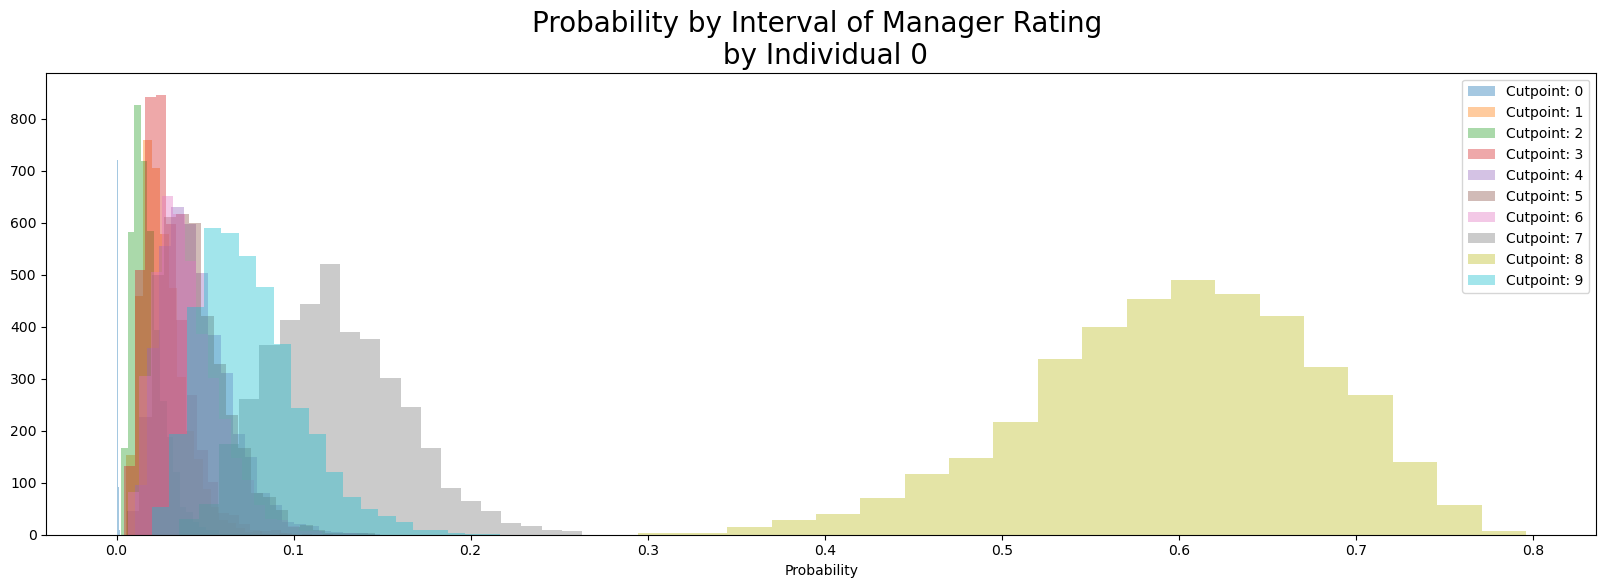

In [35]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(n_levels):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20, alpha=0.4)
ax.set_xlabel("Probability")
ax.set_title("Probability by Interval of Manager Rating \n by Individual 0", fontsize=20)
ax.legend();